# 1. Import needed libraries

In [1]:
!pip install tensorflow==2.9.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.6 MB/s eta 0:00:0000:0100:01











     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.9 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.3 MB/s eta 0:00:00





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.1 MB/s eta 0:00:00:00:01




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 37.1 MB/s eta 0:00:00












     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 95.7 MB/s eta 0:00:00:00:01



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 57.8 MB/s eta 0:00:00















  Attempting uninstall: keras

    Found existing installation: keras 2.13.1

    Uninstalling keras-2.13.1:

      Successfully uninstalled keras-2.13.1

  Attempting uninstall: flatbuffers

    Found existing installation: flatbuffers 23.5.26

    Uninstalling flatbuffers-23

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2.1 Load data

In [3]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [4]:
tr_df = train_df('/kaggle/input/cvproj/Dataset')

In [5]:
tr_df

,Class Path,Class
0,/kaggle/input/cvproj/Dataset/Alaa/photo_2023-1...,Alaa
1,/kaggle/input/cvproj/Dataset/Alaa/photo_2023-1...,Alaa
2,/kaggle/input/cvproj/Dataset/Alaa/photo_2023-1...,Alaa
3,/kaggle/input/cvproj/Dataset/Alaa/photo_2023-1...,Alaa
4,/kaggle/input/cvproj/Dataset/Alaa/photo_2023-1...,Alaa
...,...,...
937,/kaggle/input/cvproj/Dataset/Yousef/photo_2023...,Yousef
938,/kaggle/input/cvproj/Dataset/Yousef/photo_2023...,Yousef
939,/kaggle/input/cvproj/Dataset/Yousef/photo_2023...,Yousef
940,/kaggle/input/cvproj/Dataset/Yousef/photo_2023...,Yousef


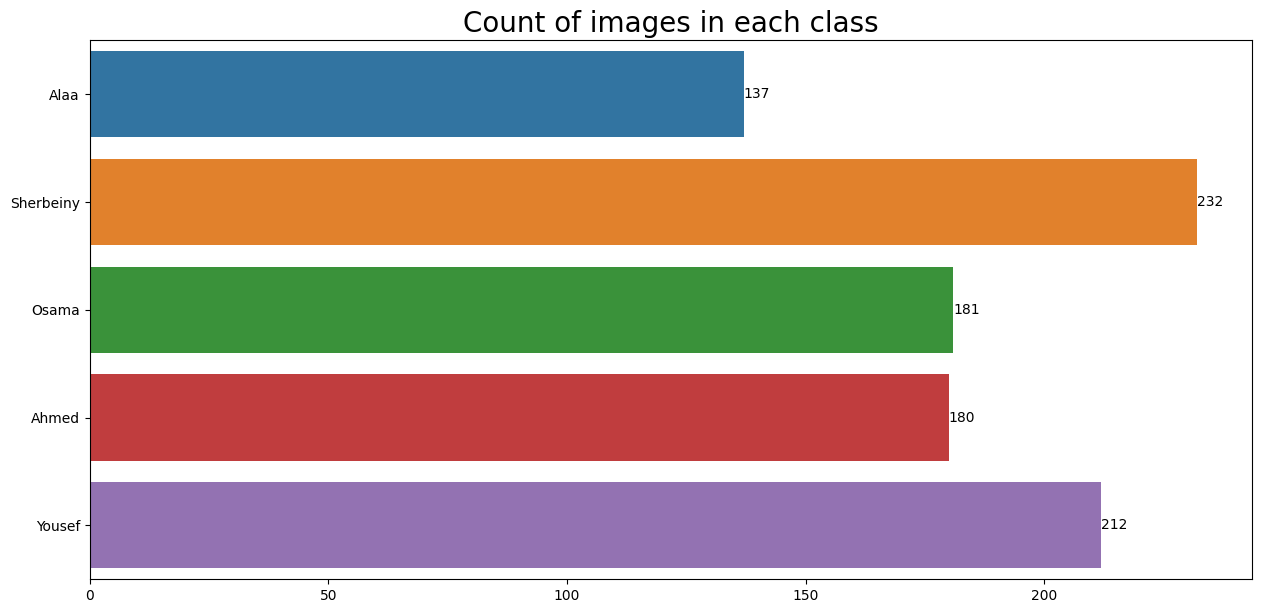

In [8]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

## 2.2 Split data into train, test, valid

In [10]:
tr_df, _ = train_test_split(tr_df, train_size=.8, shuffle= True, random_state=20)
valid_df, ts_df = train_test_split(_, train_size=.5,shuffle= True, random_state=20)

In [11]:
valid_df

,Class Path,Class
266,/kaggle/input/cvproj/Dataset/Sherbeiny/photo_2...,Sherbeiny
837,/kaggle/input/cvproj/Dataset/Yousef/photo_2023...,Yousef
588,/kaggle/input/cvproj/Dataset/Ahmed/photo_2023-...,Ahmed
137,/kaggle/input/cvproj/Dataset/Sherbeiny/photo_2...,Sherbeiny
477,/kaggle/input/cvproj/Dataset/Osama/photo_2023-...,Osama
...,...,...
141,/kaggle/input/cvproj/Dataset/Sherbeiny/photo_2...,Sherbeiny
36,/kaggle/input/cvproj/Dataset/Alaa/photo_2023-1...,Alaa
770,/kaggle/input/cvproj/Dataset/Yousef/photo_2023...,Yousef
317,/kaggle/input/cvproj/Dataset/Sherbeiny/photo_2...,Sherbeiny


## 2.3 Data preprocessing

In [12]:
batch_size = 16
img_size = (224,224)

gen = ImageDataGenerator(rotation_range=30,
                         shear_range=.1,
                         zoom_range=.1,
                         horizontal_flip=True)

test_gen = ImageDataGenerator()


tr_gen = gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                 y_col='Class',batch_size=batch_size,
                                 target_size=img_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',batch_size=batch_size,
                                    target_size=img_size)

ts_gen = test_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                y_col='Class',batch_size=batch_size,
                                 target_size=img_size,shuffle=False)

Found 753 validated image filenames belonging to 5 classes.

Found 94 validated image filenames belonging to 5 classes.

Found 95 validated image filenames belonging to 5 classes.


In [17]:
#gen.flow_from_dataframe?

## 2.4 Getting samples from data

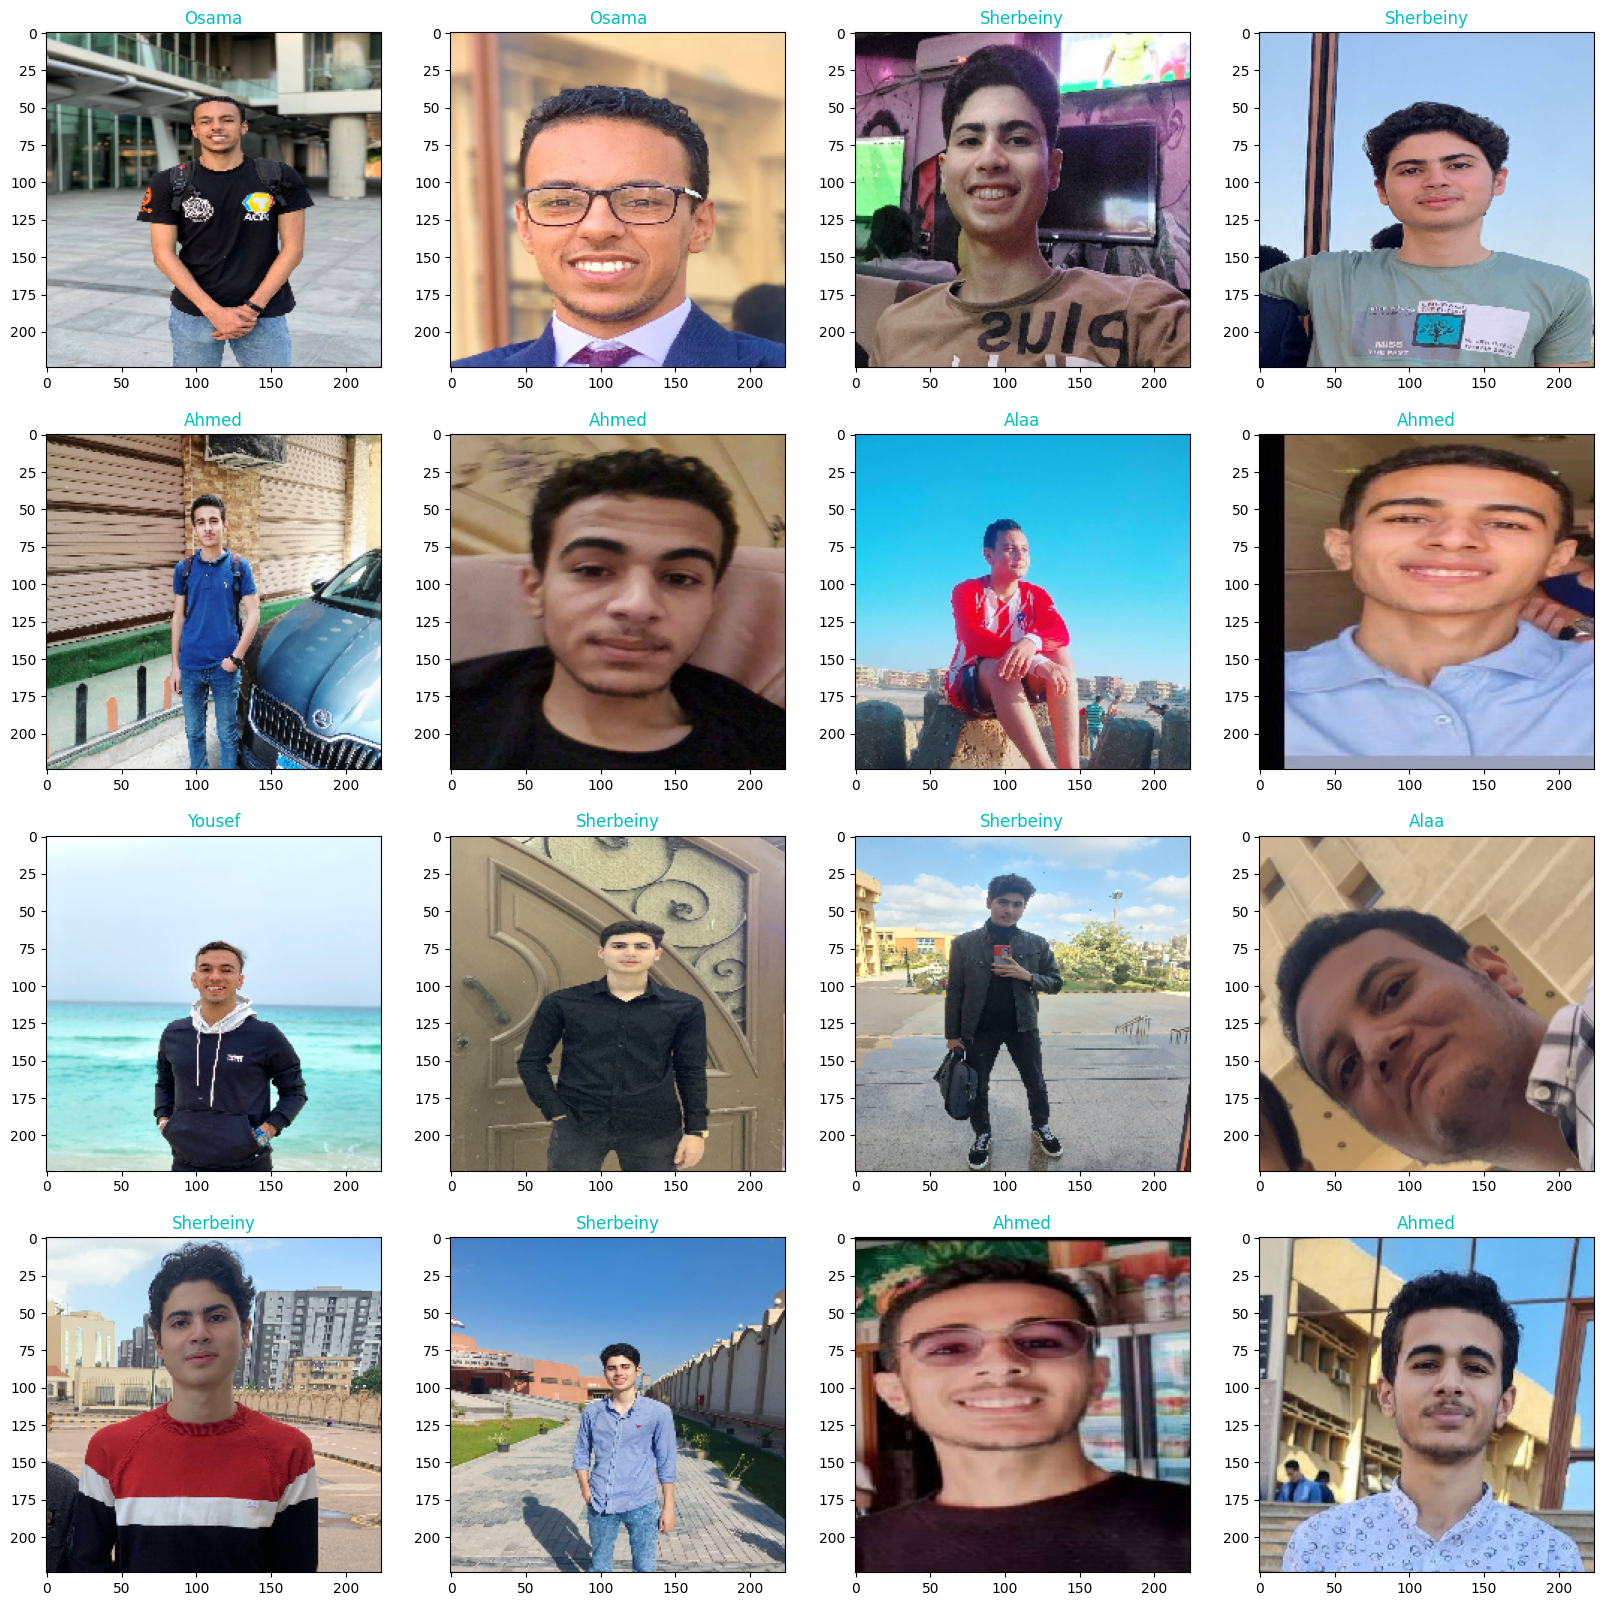

In [27]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='c')
plt.show()

In [11]:
#images

In [12]:
#class_dict

In [13]:
#labels

In [14]:
#gen??

# 3. Building Deep Learning Model

In [66]:
# model = Sequential()

# model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=img_shape))
# model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(256, kernel_size=(4, 4), padding='same', activation='relu'))
# model.add(Conv2D(256, kernel_size=(4, 4), padding='same', activation='relu'))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
# model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
# model.add(MaxPooling2D(3,3))

# model.add(Flatten())

# model.add(Dense(512,activation = "relu"))
# model.add(Dropout(.5))
# model.add(Dense(256,activation = "relu"))
# model.add(Dropout(.45))
# model.add(Dense(5,activation = "softmax")) 

# model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

# model.summary()


img_shape=(224,224,3)
base_model = EfficientNetB3(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(512, activation= 'relu'),
    Dropout(rate= 0.4),
    Dense(5, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 efficientnetb3 (Functional)  (None, 1536)             10783535  

                                                                 

 dense_2 (Dense)             (None, 512)               786944    

                                                                 

 dropout_1 (Dropout)         (None, 512)               0         

                                                                 

 dense_3 (Dense)             (None, 5)                 2565      

                                                                 


Total params: 11,573,044

Trainable params: 789,509

Non-trainable params: 10,783,535

_________________________________________________________________


In [76]:
for layer in base_model.layers[200:]:
    layer.trainable = True

In [77]:
model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 efficientnetb3 (Functional)  (None, 1536)             10783535  

                                                                 

 dense_2 (Dense)             (None, 512)               786944    

                                                                 

 dropout_1 (Dropout)         (None, 512)               0         

                                                                 

 dense_3 (Dense)             (None, 5)                 2565      

                                                                 


Total params: 11,573,044

Trainable params: 1,663,903

Non-trainable params: 9,909,141

_________________________________________________________________


In [83]:
for layer in base_model.layers:
    layer.trainable = True

In [84]:
model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 efficientnetb3 (Functional)  (None, 1536)             10783535  

                                                                 

 dense_2 (Dense)             (None, 512)               786944    

                                                                 

 dropout_1 (Dropout)         (None, 512)               0         

                                                                 

 dense_3 (Dense)             (None, 5)                 2565      

                                                                 


Total params: 11,573,044

Trainable params: 11,485,741

Non-trainable params: 87,303

_________________________________________________________________


# 4. Training

In [52]:
#     layer.trainable = False
hist = model.fit(tr_gen,
                 epochs=20,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/20

48/48 [==============================] - 37s 453ms/step - loss: 0.7122 - accuracy: 0.8991 - precision_5: 0.9080 - recall_5: 0.8911 - val_loss: 7.2992 - val_accuracy: 0.8085 - val_precision_5: 0.8085 - val_recall_5: 0.8085

Epoch 2/20

48/48 [==============================] - 19s 391ms/step - loss: 0.1962 - accuracy: 0.9575 - precision_5: 0.9586 - recall_5: 0.9535 - val_loss: 0.3215 - val_accuracy: 0.9149 - val_precision_5: 0.9444 - val_recall_5: 0.9043

Epoch 3/20

48/48 [==============================] - 19s 400ms/step - loss: 0.0933 - accuracy: 0.9761 - precision_5: 0.9799 - recall_5: 0.9721 - val_loss: 0.2923 - val_accuracy: 0.9787 - val_precision_5: 0.9891 - val_recall_5: 0.9681

Epoch 4/20

48/48 [==============================] - 19s 393ms/step - loss: 0.0660 - accuracy: 0.9867 - precision_5: 0.9866 - recall_5: 0.9801 - val_loss: 0.0929 - val_accuracy: 0.9681 - val_precision_5: 0.9783 - val_recall_5: 0.9574

Epoch 5/20

48/48 [==============================] - 19s 397

In [16]:
# layer.trainable[200: ] = True
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10

48/48 [==============================] - 37s 452ms/step - loss: 1.2814 - accuracy: 0.6428 - precision_2: 0.6754 - recall_2: 0.6162 - val_loss: 0.5246 - val_accuracy: 0.8191 - val_precision_2: 0.8556 - val_recall_2: 0.8191

Epoch 2/10

48/48 [==============================] - 19s 389ms/step - loss: 0.3192 - accuracy: 0.8858 - precision_2: 0.9119 - recall_2: 0.8659 - val_loss: 0.3826 - val_accuracy: 0.9043 - val_precision_2: 0.9140 - val_recall_2: 0.9043

Epoch 3/10

48/48 [==============================] - 19s 392ms/step - loss: 0.1945 - accuracy: 0.9349 - precision_2: 0.9519 - recall_2: 0.9203 - val_loss: 0.3492 - val_accuracy: 0.9255 - val_precision_2: 0.9255 - val_recall_2: 0.9255

Epoch 4/10

48/48 [==============================] - 19s 386ms/step - loss: 0.1791 - accuracy: 0.9469 - precision_2: 0.9541 - recall_2: 0.9389 - val_loss: 0.1047 - val_accuracy: 0.9681 - val_precision_2: 0.9681 - val_recall_2: 0.9681

Epoch 5/10

48/48 [==============================] - 19s 386

In [ ]:
# layer.trainable = True
hist = model.fit(tr_gen,
                 epochs=25,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/25

48/48 [==============================] - 40s 461ms/step - loss: 0.9959 - accuracy: 0.7596 - precision_15: 0.7960 - recall_15: 0.7463 - val_loss: 0.2791 - val_accuracy: 0.9255 - val_precision_15: 0.9239 - val_recall_15: 0.9043

Epoch 2/25

48/48 [==============================] - 19s 396ms/step - loss: 0.2582 - accuracy: 0.9084 - precision_15: 0.9335 - recall_15: 0.8951 - val_loss: 0.1807 - val_accuracy: 0.9468 - val_precision_15: 0.9570 - val_recall_15: 0.9468

Epoch 3/25

48/48 [==============================] - 19s 397ms/step - loss: 0.1612 - accuracy: 0.9416 - precision_15: 0.9511 - recall_15: 0.9296 - val_loss: 0.1037 - val_accuracy: 0.9681 - val_precision_15: 0.9681 - val_recall_15: 0.9681

Epoch 4/25

48/48 [==============================] - 20s 404ms/step - loss: 0.1293 - accuracy: 0.9615 - precision_15: 0.9638 - recall_15: 0.9548 - val_loss: 0.1494 - val_accuracy: 0.9574 - val_precision_15: 0.9574 - val_recall_15: 0.9574

Epoch 5/25

48/48 [=========================

In [26]:
#model.fit?

In [96]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_15', 'recall_15', 'val_loss', 'val_accuracy', 'val_precision_15', 'val_recall_15'])

## 4.1 Visualize model performance

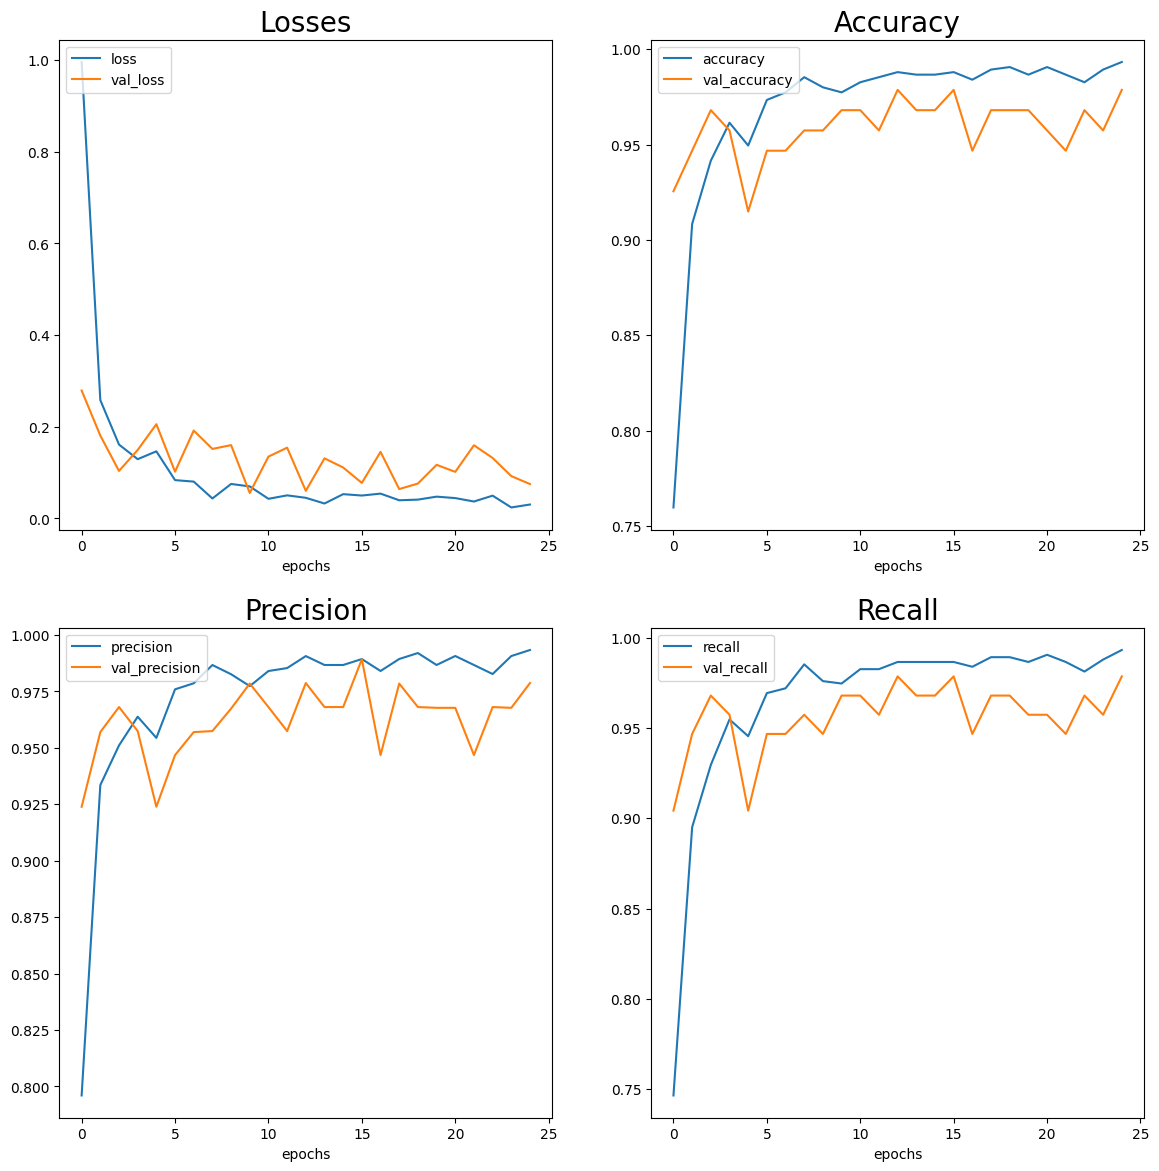

In [97]:
plt.figure(figsize= (14, 14))

plt.subplot(2,2,1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,3)
plt.plot(hist.history['precision_15'], label='precision')
plt.plot(hist.history['val_precision_15'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,4)
plt.plot(hist.history['recall_15'], label='recall')
plt.plot(hist.history['val_recall_15'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [91]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

48/48 [==============================] - 16s 338ms/step - loss: 7.1973e-05 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000

6/6 [==============================] - 2s 333ms/step - loss: 0.0845 - accuracy: 0.9681 - precision_15: 0.9681 - recall_15: 0.9681

6/6 [==============================] - 1s 183ms/step - loss: 0.0927 - accuracy: 0.9895 - precision_15: 0.9895 - recall_15: 0.9895

Train Loss:  7.19726158422418e-05

Train Accuracy:  1.0

--------------------

Validation Loss:  0.08454068750143051

Validation Accuracy:  0.9680851101875305

--------------------

Test Loss:  0.09274569898843765

Test Accuracy:  0.9894737005233765


In [92]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

6/6 [==============================] - 1s 195ms/step


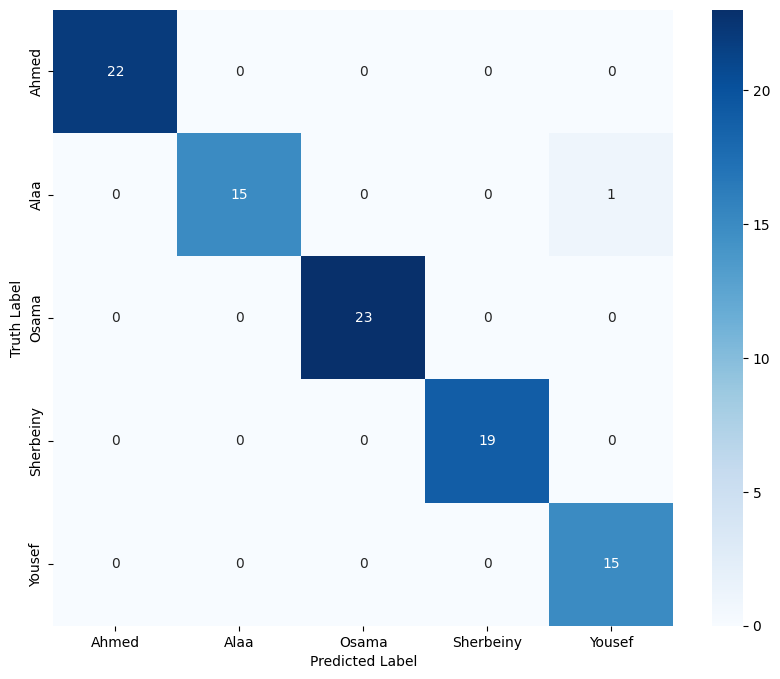

In [93]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [94]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support



           0       1.00      1.00      1.00        22

           1       1.00      0.94      0.97        16

           2       1.00      1.00      1.00        23

           3       1.00      1.00      1.00        19

           4       0.94      1.00      0.97        15



    accuracy                           0.99        95

   macro avg       0.99      0.99      0.99        95

weighted avg       0.99      0.99      0.99        95




## 5.2 Testing

In [4]:
def predict(img_path, model=new_model):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    from tensorflow.keras.applications.efficientnet import preprocess_input
    label = ['Ahmed', 'Alaa', 'Osama', 'Sherbeiny', 'Yousef']
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 0s 119ms/step


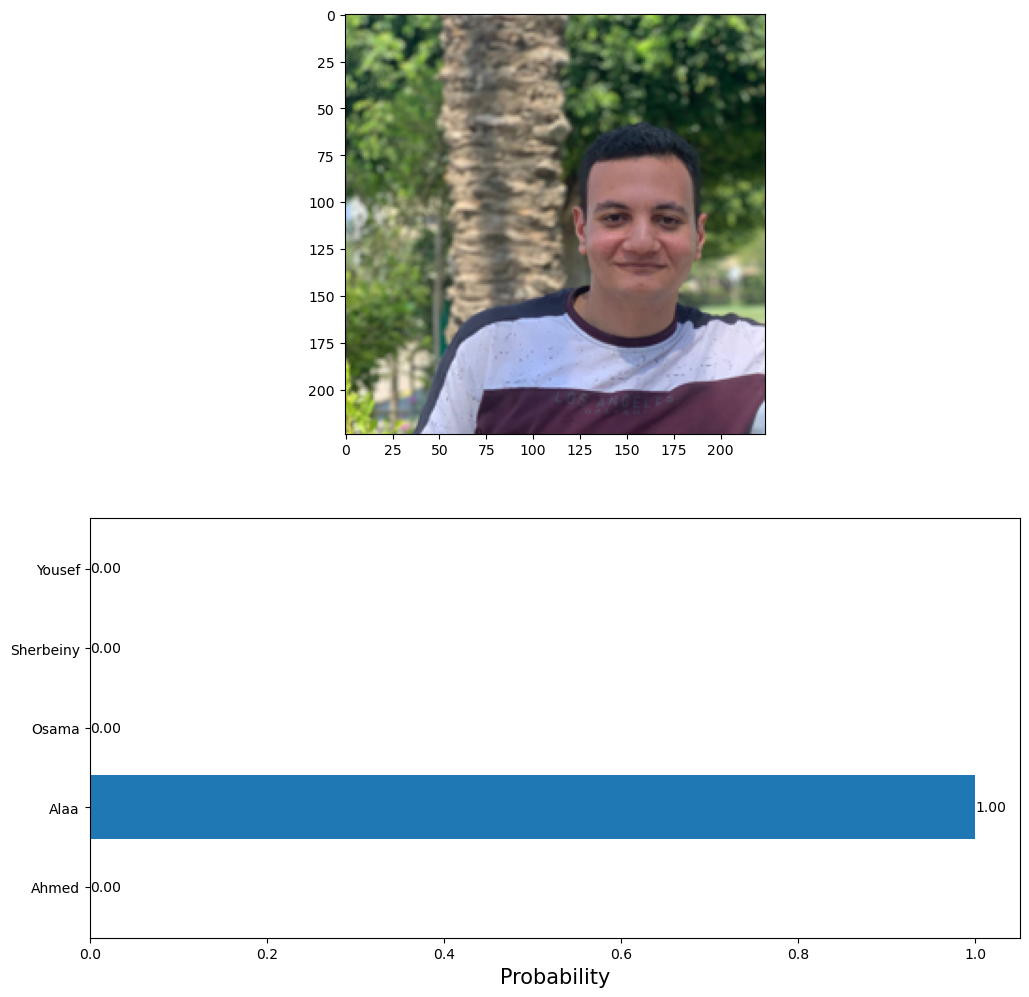

In [11]:
predict('3laa.jpg', model)

# 6. Save the model

In [95]:
model.save('CV_Project.h5')

In [1]:
from tensorflow.keras.models import load_model
new_model = load_model('CV_Project.h5')

In [ ]:
predict('/kaggle/input/osssss/photo_2023-10-11_06-48-18.jpg')

# 7. Real-time detection

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.image import resize

class_names = {0: "Ahmed", 1: "Alaa", 2: "Osama", 3: "Sherbiny", 4: "Yousef"}
model = load_model('CV_Project.h5')
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized_frame = resize(rgb_frame, (224, 224))
    preprocessed_frame = preprocess_input(resized_frame)

    predictions = model.predict(np.expand_dims(preprocessed_frame, axis=0))

    predicted_class = np.argmax(predictions)
    max_probability = predictions[0][predicted_class]

    recognized_name = class_names.get(predicted_class, "Unknown")

    label = f"{recognized_name} ({max_probability:.2f})"

    color = (0, 255, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    cv2.rectangle(frame, (0, 0), (224, 50), (0, 0, 0), -1)
    cv2.putText(frame, label, (10, 30), font, font_scale, color, thickness)

    cv2.imshow("Face Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 3s 3s/step

1/1 [==============================] - 0s 84ms/step

1/1 [==============================] - 0s 81ms/step

1/1 [==============================] - 0s 77ms/step

1/1 [==============================] - 0s 76ms/step

1/1 [==============================] - 0s 75ms/step

1/1 [==============================] - 0s 74ms/step

1/1 [==============================] - 0s 76ms/step

1/1 [==============================] - 0s 75ms/step

1/1 [==============================] - 0s 74ms/step

1/1 [==============================] - 0s 75ms/step

1/1 [==============================] - 0s 77ms/step

1/1 [==============================] - 0s 79ms/step

1/1 [==============================] - 0s 76ms/step

1/1 [==============================] - 0s 77ms/step

1/1 [==============================] - 0s 83ms/step

1/1 [==============================] - 0s 88ms/step

1/1 [==============================] - 0s 95ms/step

1/1 [==============================] - 0s 104ms/